In [1]:
import geopandas as gpd
import pandas as pd
import os
import json
import pylab as pl
import StringIO
import requests
import zipfile
import urllib2
import numpy as np
from scipy.stats import chisquare
import numpy.polynomial.polynomial as poly
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.tools.plotting import scatter_matrix
% pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['chisquare', 'poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
DFDATA = os.getenv('DFDATA')
PUI2016 = os.getenv('PUI2016')
PUIDATA = os.getenv('PUIDATA')

In [3]:
s = json.load(open(PUI2016 + '/fbb_matplotlibrc.json'))
pl.rcParams.update(s)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Compare the energy consumed by a building to the number of units in the building

In [4]:
#data on energy consumption
url = "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD"
"curl -o " + PUI2016 + "/energy.csv " + url
energy = pd.DataFrame.from_csv(url) 
energy.head()

,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,No,None,NaN,NaN,NaN,NaN,NaN,440360.0,NaN,1.0
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,None,Not Available,NaN,NaN,NaN,50000,NaN,Multifamily Housing,NaN


In [5]:
r = requests.get("http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip") 
z = zipfile.ZipFile(StringIO.StringIO(r.content))
p = z.extractall(PUIDATA)
units = gpd.read_file(PUIDATA + "/" + "MNMapPLUTO.shp")

In [6]:
units = units[['BBL', 'UnitsTotal']]
units.head()

,BBL,UnitsTotal
0,1.015450e+09,18
1,1.007238e+09,50
2,1.016800e+09,10
3,1.013850e+09,32
4,1.011970e+09,26


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f823dc79890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f822f33d390>]], dtype=object)

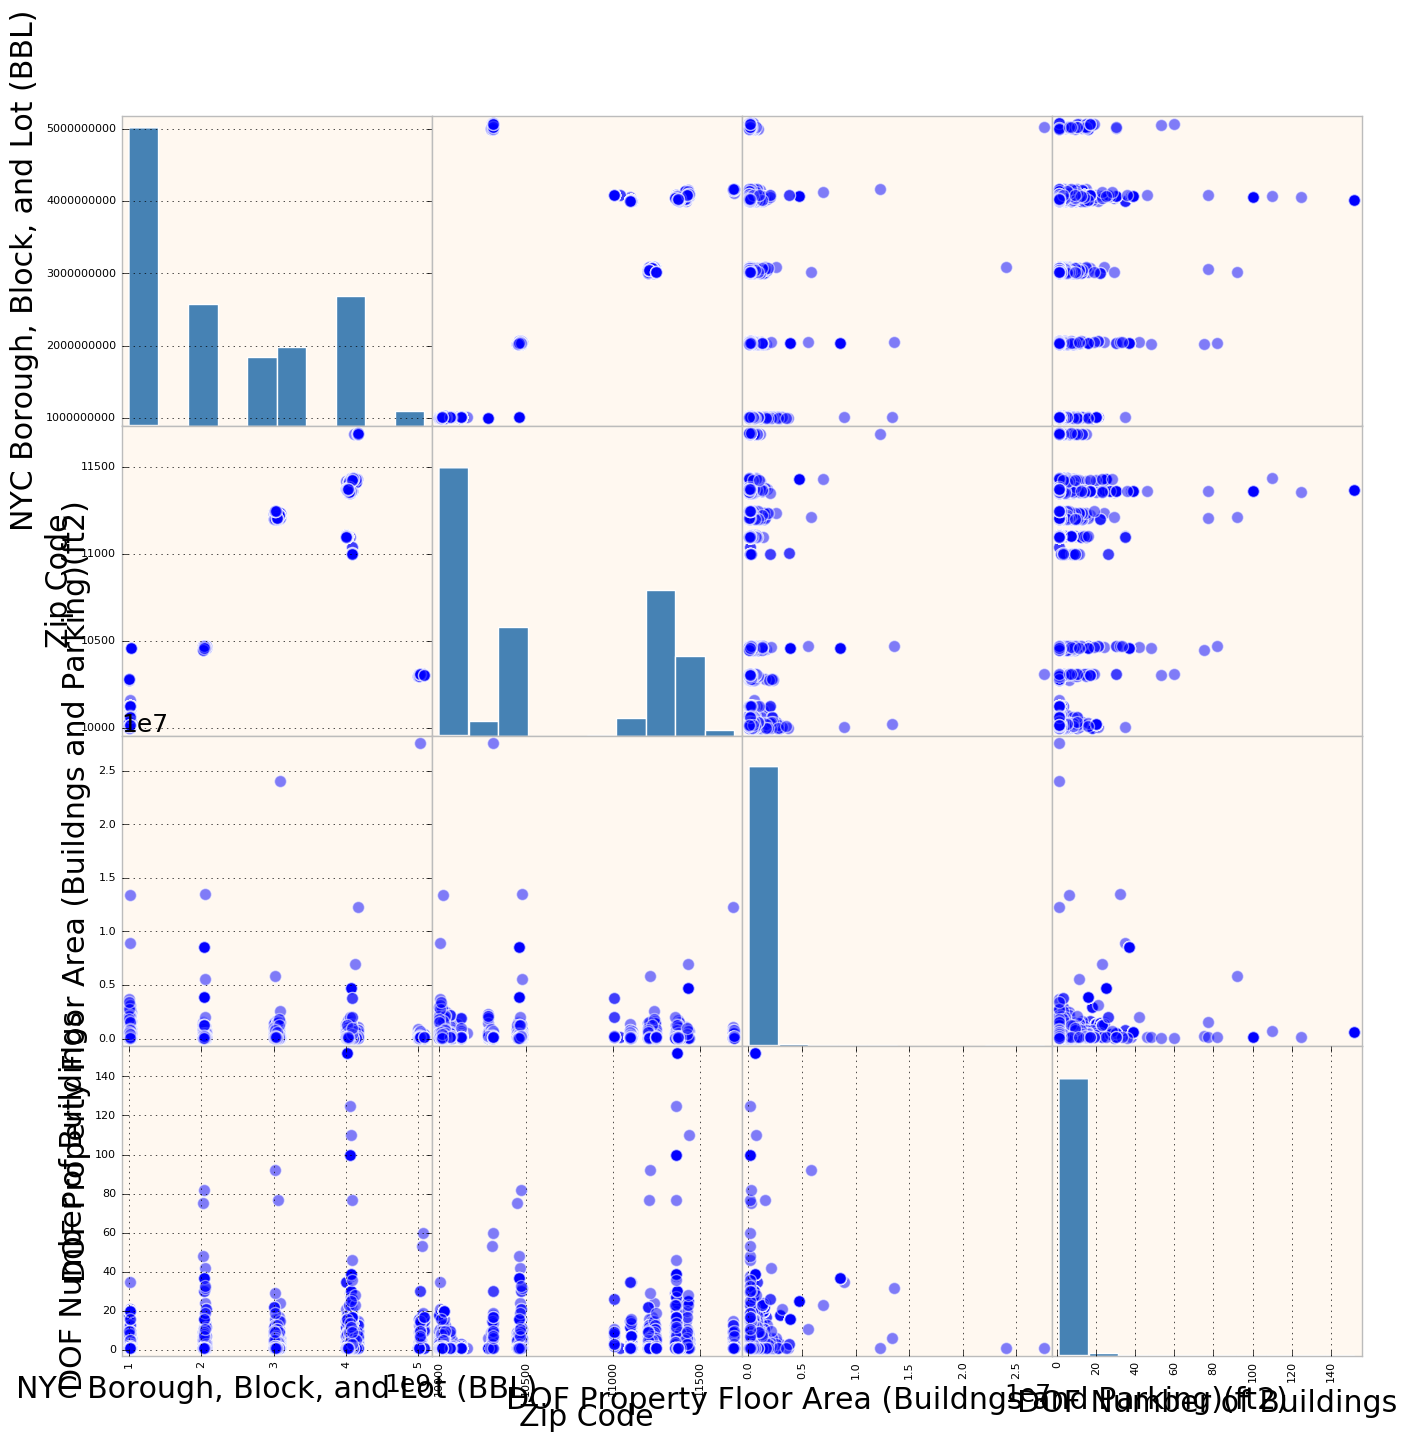

In [7]:
#scatter matrix shows that many columns don't have float values, or values that can convert to 
#float
scatter_matrix (energy, s=300, figsize=(16, 16))

### clean the energy dataset so that all values in the energy consumption column can be converted to float

In [8]:
energy = energy[['NYC Borough, Block, and Lot (BBL)', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]

In [9]:
energy.head()
len(energy)

16170

In [10]:
def canconvert(mydata):
    try:
        float(mydata)
        return True
    except ValueError:
        return False

indx = (np.vectorize(canconvert)(energy['Site EUI(kBtu/ft2)']))
print("True entries %d"%sum(indx))
energy['Site EUI(kBtu/ft2)'][~indx] = float('NaN')

indx2 = (np.vectorize(canconvert)(energy['Reported Property Floor Area (Building(s)) (ft²)']))
print("True entries %d"%sum(indx))
energy['Reported Property Floor Area (Building(s)) (ft²)'][~indx2] = float('NaN')

indx3 = (np.vectorize(canconvert)(energy['NYC Borough, Block, and Lot (BBL)']))
print("True entries %d"%sum(indx))
energy['NYC Borough, Block, and Lot (BBL)'][~indx3] = float('NaN')

True entries 15513
True entries 15513
True entries 15513


In [11]:
try:
    energy['Site EUI(kBtu/ft2)'].astype(float)
except ValueError:
    print("conversion failed")

In [12]:
try:
    units.BBL.astype(float)
except ValueError:
    print("conversion failed")

### merge the datasets on a common column name

In [13]:
units = units[units['UnitsTotal']>10]
units.head()

,BBL,UnitsTotal
0,1.015450e+09,18
1,1.007238e+09,50
3,1.013850e+09,32
4,1.011970e+09,26
8,1.022240e+09,30


In [14]:
energy = energy.rename(columns = {'NYC Borough, Block, and Lot (BBL)':'BBL'})
energy.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,1.000410e+09,NaN,918919
14354,4.021460e+09,NaN,NaN
12150,2.027620e+09,NaN,64200
12590,1.006700e+09,NaN,NaN
15591,2.048300e+09,NaN,50000


In [15]:
energy['Site EUI(kBtu/ft2)'] = energy['Site EUI(kBtu/ft2)'].astype(float)
energy['Reported Property Floor Area (Building(s)) (ft²)'] = energy['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

In [16]:
#create new columns for total energy consumption
energy['EnergyTotal'] = energy['Site EUI(kBtu/ft2)'] * energy['Reported Property Floor Area (Building(s)) (ft²)']

In [17]:
merged = pd.merge(energy, units, on='BBL')
merged.head()
print(len(merged))
merged = merged.dropna()
print(len(merged))

5201
4266


In [18]:
#scatter_matrix (merged_dropped, s=30, figsize=(16, 16))

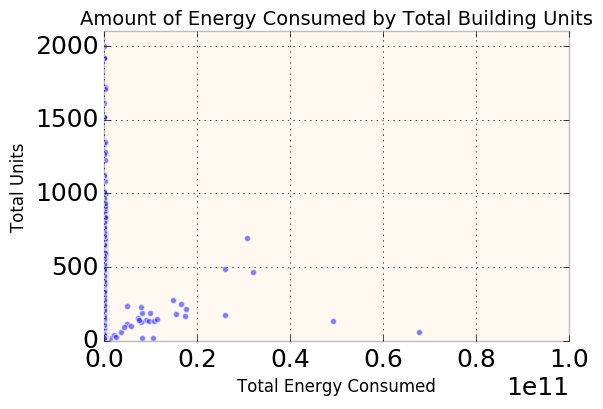

In [19]:
pl.scatter(x=merged['EnergyTotal'], y=merged['UnitsTotal'],alpha=0.5)
pl.axis([-5, 1e11, -5, 2100])
pl.title('Amount of Energy Consumed by Total Building Units', fontsize=14)
pl.xlabel('Total Energy Consumed', fontsize=12)
pl.ylabel('Total Units', fontsize=12)
pl.show()

### Caption for plot
This plot depicts the total amount of units as a function of total energy consumed.

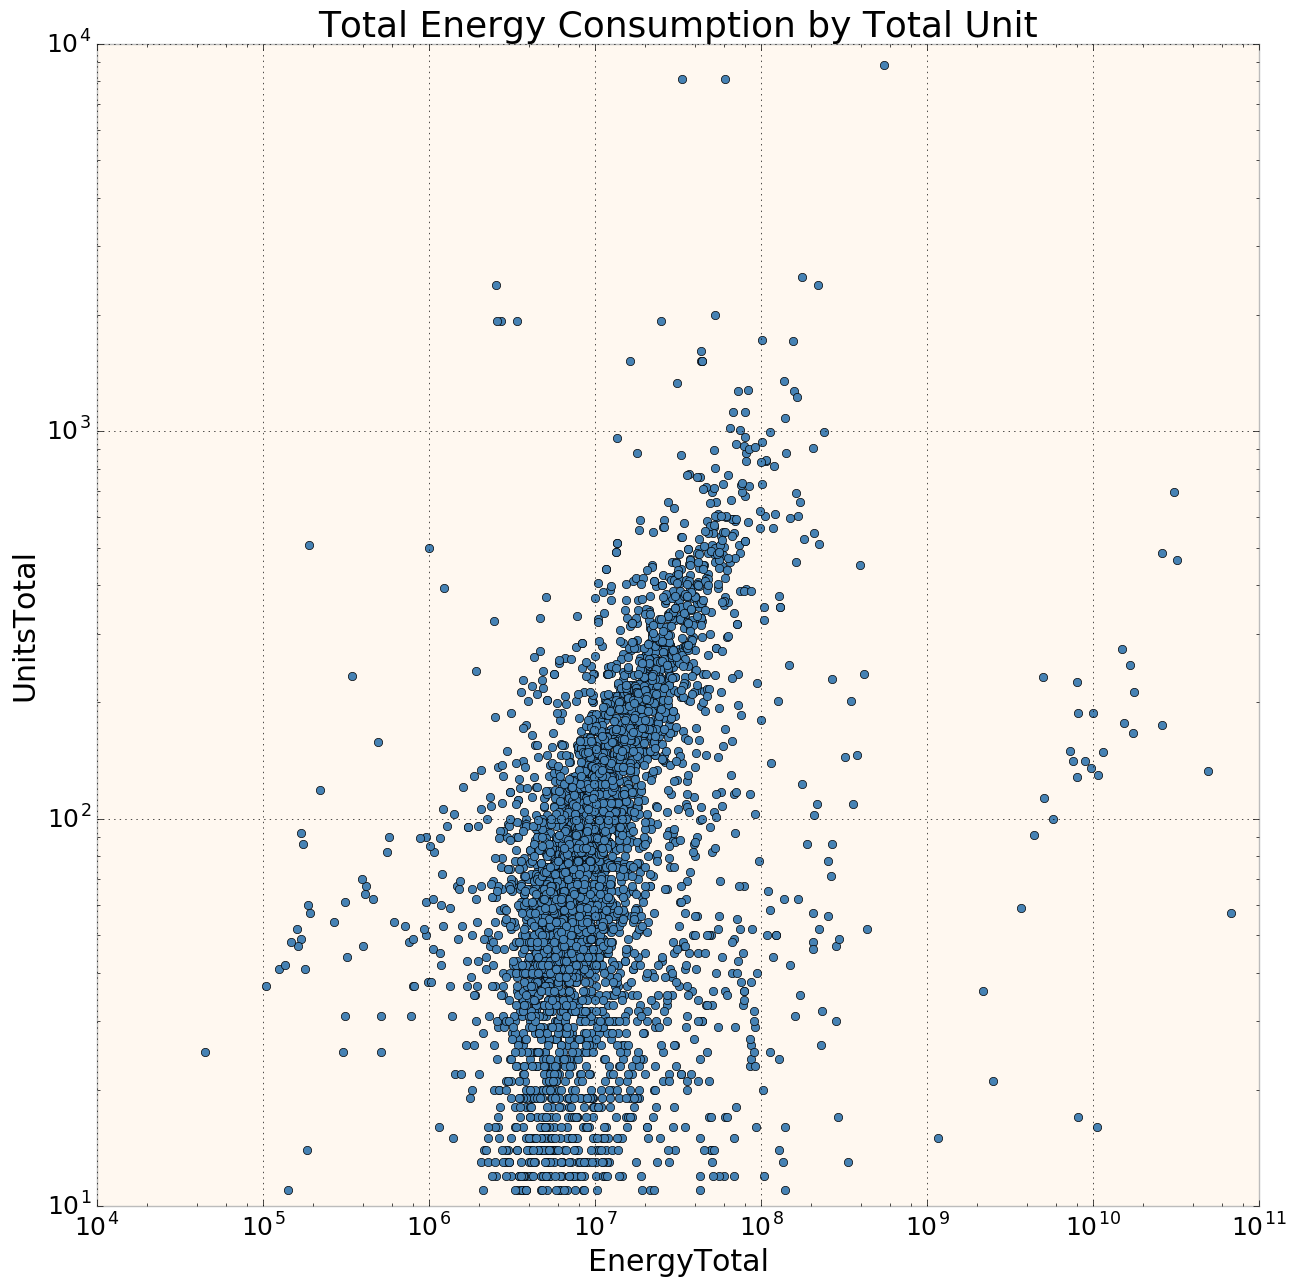

In [20]:
plt.figure(figsize=(15,15))
plt.loglog(merged['EnergyTotal'], merged['UnitsTotal'], 'o')
plt.xlim([10**4, 10**11])
plt.xlabel("EnergyTotal")
plt.ylabel("UnitsTotal")
plt.title("Total Energy Consumption by Total Unit")

### Caption for plot
This plot depicts building units as a function of energy consumption. 

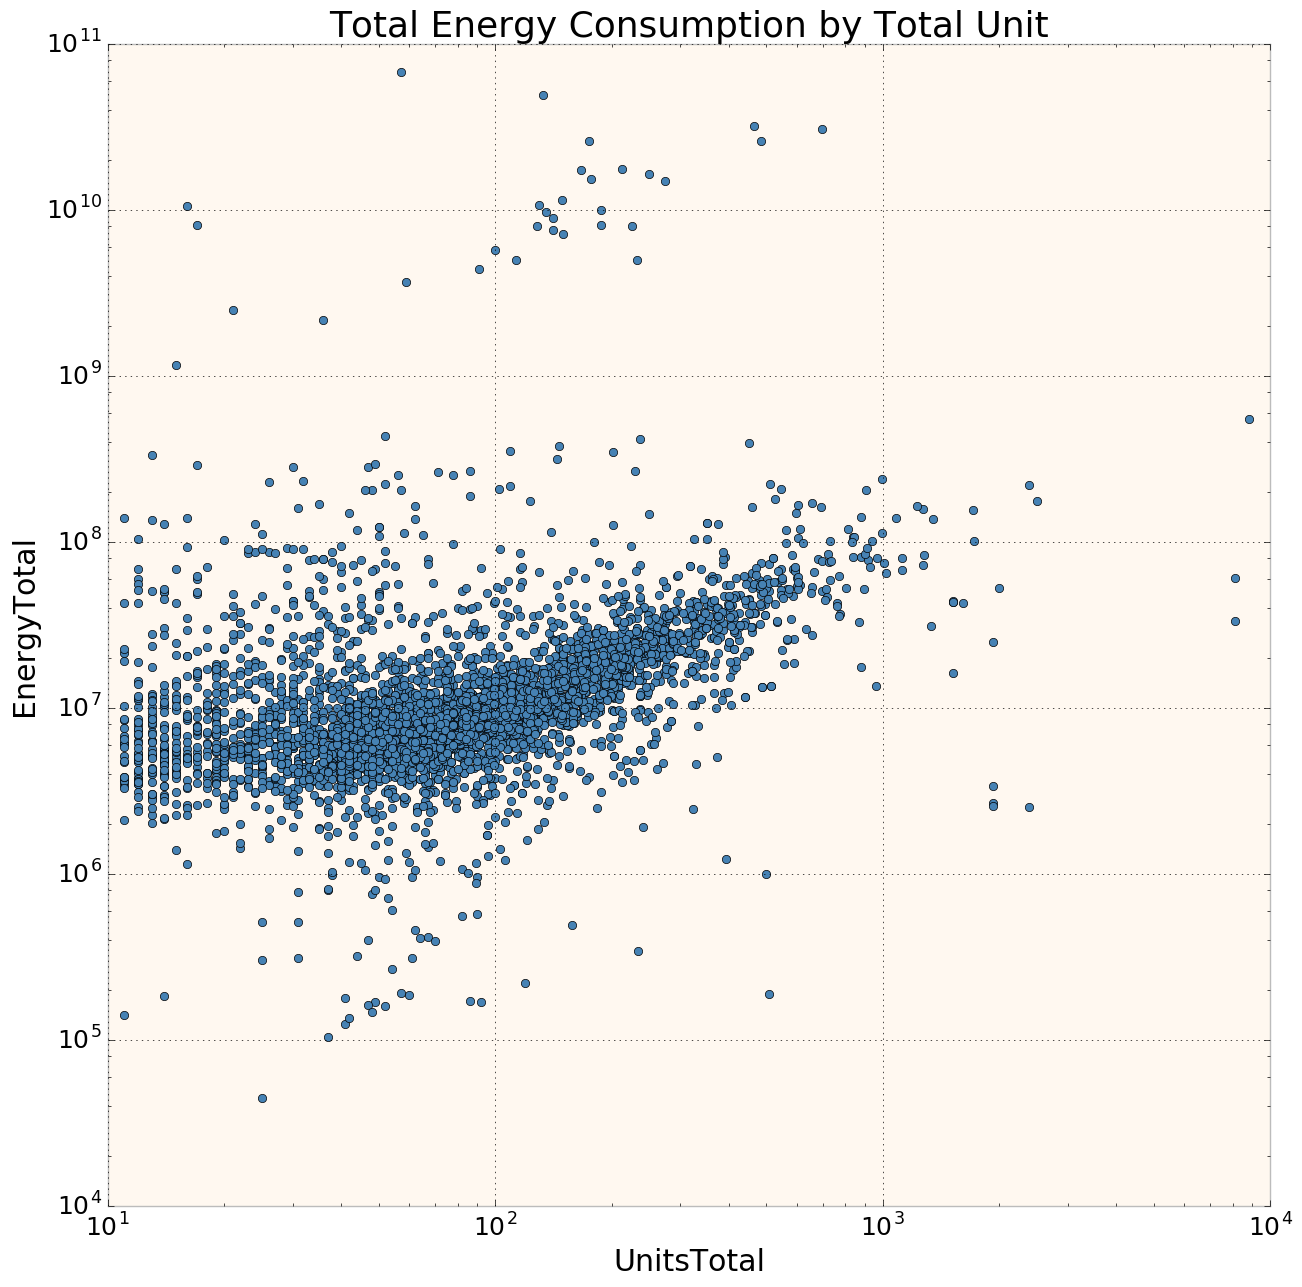

In [21]:
plt.figure(figsize=(15,15))
plt.loglog(merged['UnitsTotal'], merged['EnergyTotal'], 'o')
plt.ylim([10**4, 10**11])
plt.ylabel("EnergyTotal")
plt.xlabel("UnitsTotal")
plt.title("Total Energy Consumption by Total Unit")

### Caption for plot
This plot captures the total energy consumption as a function of building units.

### create a line of best fit in log space

In [134]:
merged = merged[merged.UnitsTotal<1000]
print(len(merged))

4237


In [132]:
linmodel_1 = sm.OLS(np.log10(merged['UnitsTotal']), sm.add_constant(np.log10(merged['EnergyTotal'])), missing='drop').fit()
print(linmodel_1.summary())

                            OLS Regression Results                            
Dep. Variable:             UnitsTotal   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     848.0
Date:                Tue, 18 Oct 2016   Prob (F-statistic):          4.23e-170
Time:                        15:52:46   Log-Likelihood:                -1654.9
No. Observations:                4237   AIC:                             3314.
Df Residuals:                    4235   BIC:                             3326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.4441      0.080     -5.526      

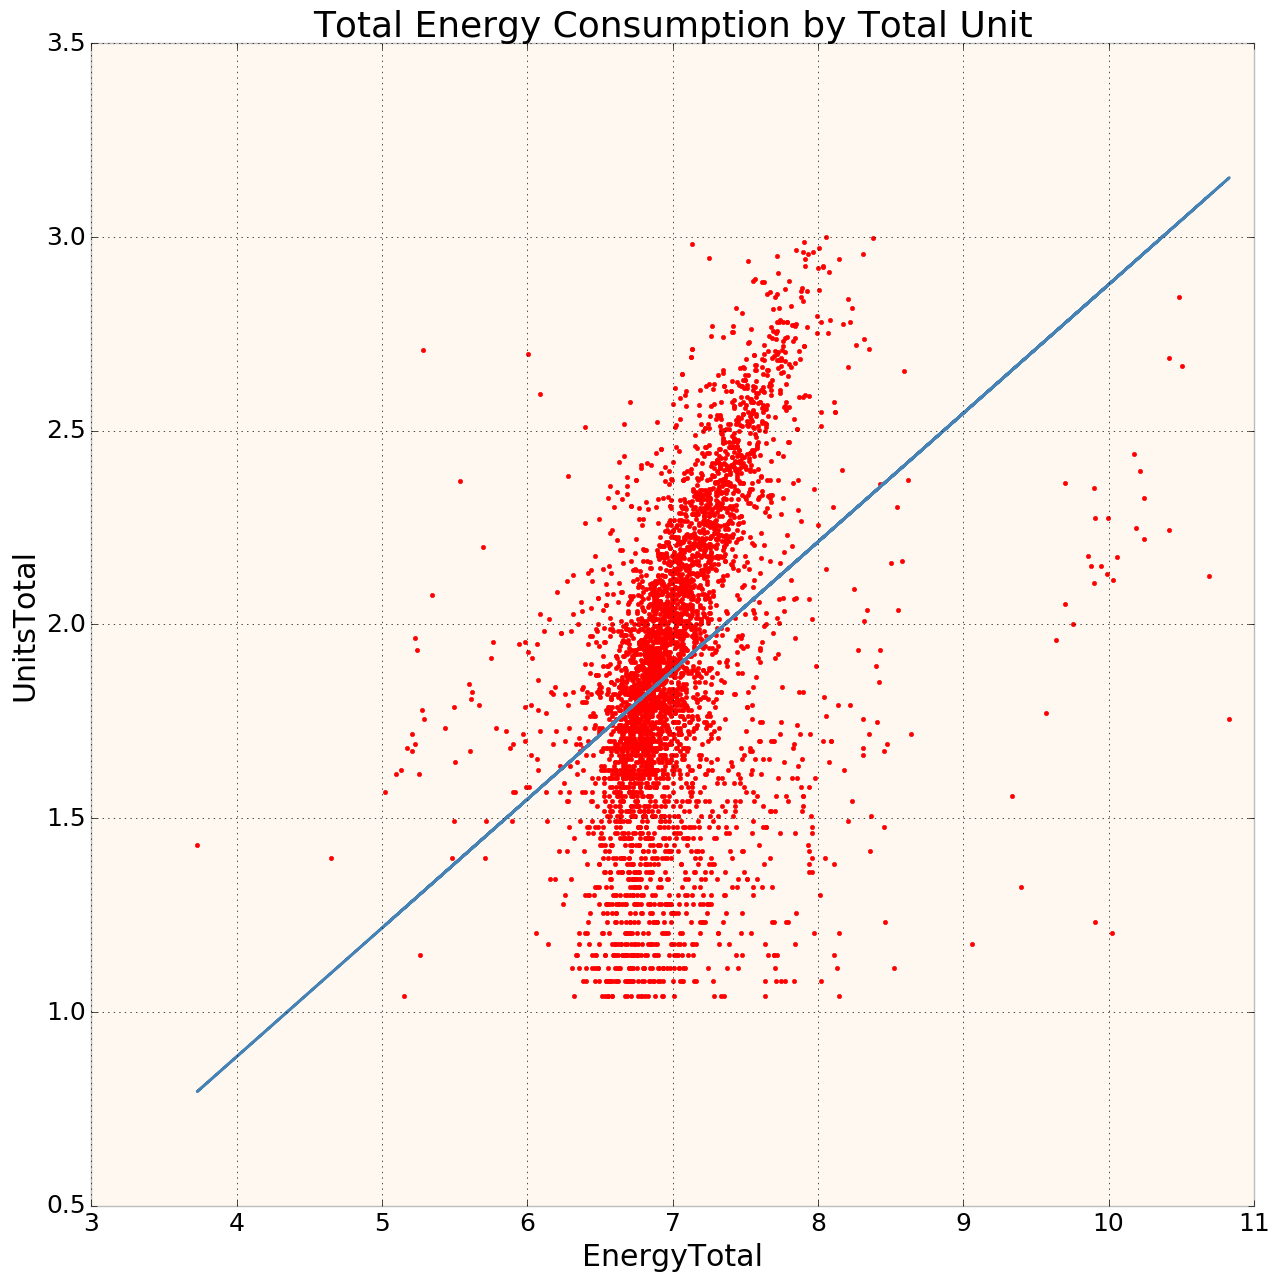

In [139]:
pl.figure(figsize=(15,15))
pl.plot(np.log10(merged['EnergyTotal']), np.log10(merged['UnitsTotal']), 'r.')
pl.plot(np.log10(merged['EnergyTotal']), linmodel_1.predict(sm.add_constant(np.log10(merged['EnergyTotal']))), '-')
pl.xlabel("EnergyTotal")
pl.ylabel("UnitsTotal")
pl.title("Total Energy Consumption by Total Unit")

### Caption for plot
This plot depicts building units as a function of energy consumption and includes a fitted line.

In [140]:
#fit line for energy as a function of units
linmodel_2 = sm.OLS(np.log10(merged['EnergyTotal']), sm.add_constant(np.log10(merged['UnitsTotal'])), missing='drop').fit()
print(linmodel_2.summary())

                            OLS Regression Results                            
Dep. Variable:            EnergyTotal   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     848.0
Date:                Tue, 18 Oct 2016   Prob (F-statistic):          4.23e-170
Time:                        15:59:20   Log-Likelihood:                -2532.2
No. Observations:                4237   AIC:                             5068.
Df Residuals:                    4235   BIC:                             5081.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0812      0.033    182.547      0.0

[ 6.95953147  6.7746521   6.7746521  ...,  6.67209787  6.88058932
  6.65704371]


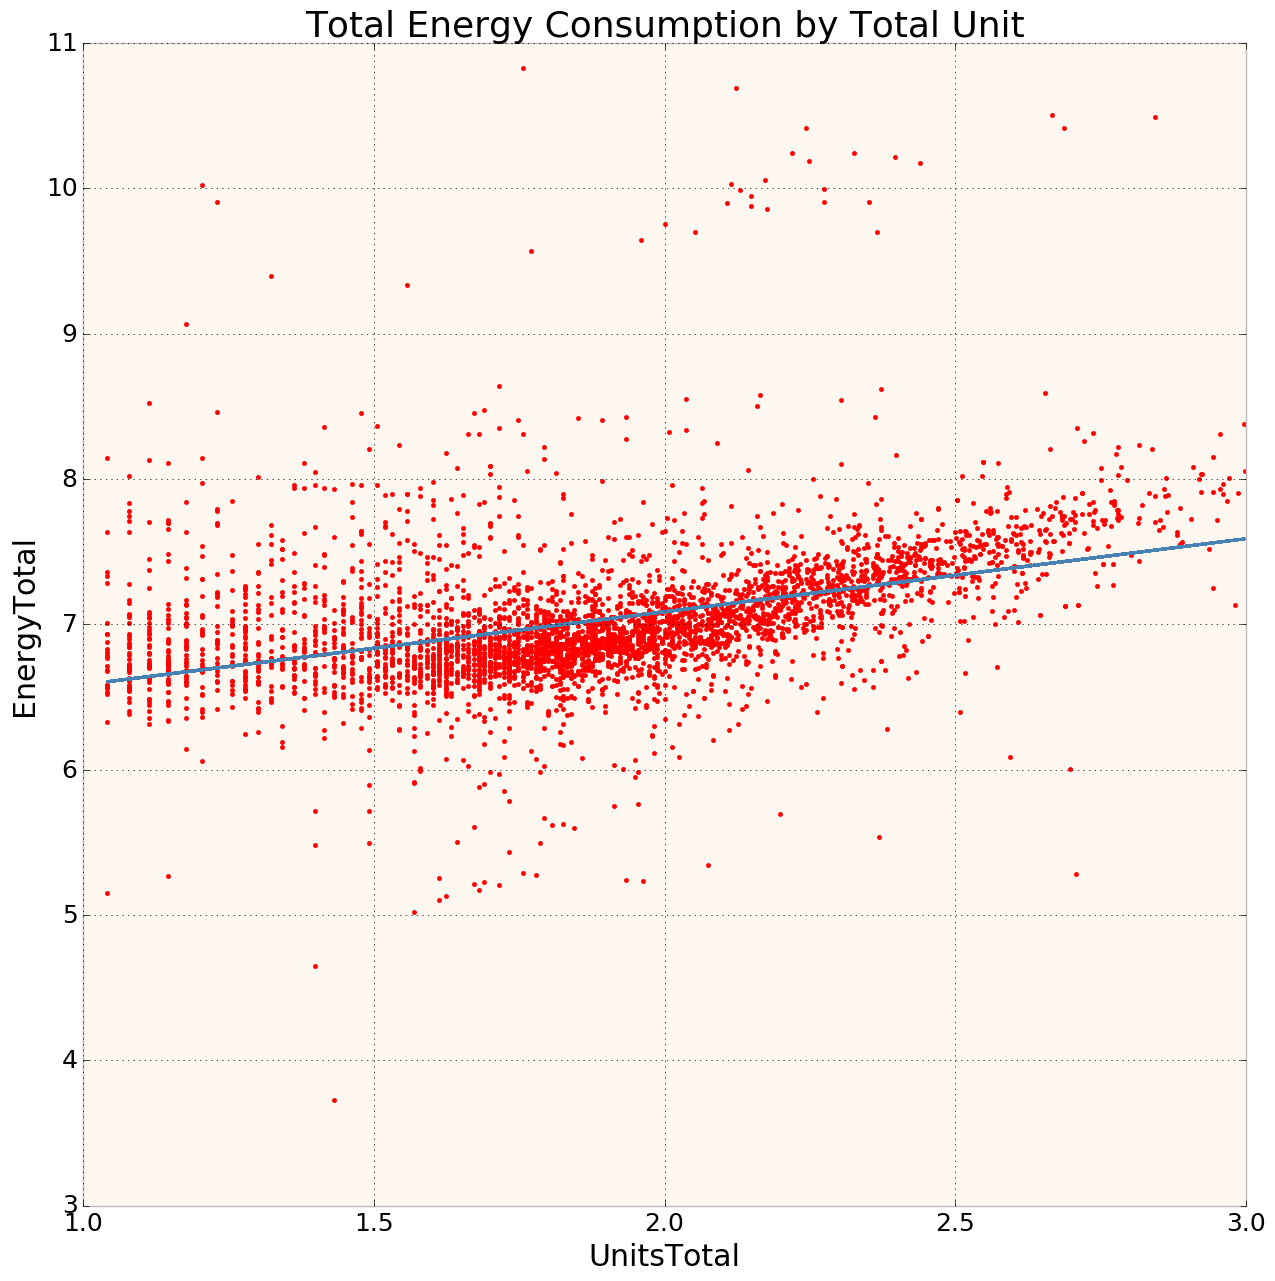

In [142]:
plt.figure(figsize=(15,15))
print(linmodel_2.predict(sm.add_constant(np.log10(merged['UnitsTotal']))))
pl.plot(np.log10(merged['UnitsTotal']), np.log10(merged['EnergyTotal']), 'r.')
pl.plot(np.log10(merged['UnitsTotal']), linmodel_eu.predict(sm.add_constant(np.log10(merged['UnitsTotal']))), '-')
plt.ylabel("EnergyTotal")
plt.xlabel("UnitsTotal")
plt.title("Total Energy Consumption by Total Unit")

### Caption for plot
This plot depicts energy consumption by total building units and fits an OLS line.

### determine which fit is better by calculating the chi square

In [144]:
resids = (linmodel_2.predict(sm.add_constant(np.log10(merged['UnitsTotal']))) - np.log10(merged['EnergyTotal']).values)**2
mychisq = resids / (np.log10(merged['EnergyTotal']).values)
mychisq.sum()

108.54704512965156

In [145]:
resids_2 = (linmodel_1.predict(sm.add_constant(np.log10(merged['EnergyTotal']))) - np.log10(merged['UnitsTotal']).values)**2
mychisq_2 = resids_2 / (np.log10(merged['UnitsTotal']).values)
mychisq_2.sum()

332.62103097218744

### fit a second degree curve of x = units and y = energy  to the datasets: ax^2+bx+c

In [35]:
#will say that x = units = eu_obs, where the last variable is a list of all the observed values
#of units in log form

In [38]:
y = np.log10(merged['EnergyTotal'])
x = np.log10(merged['UnitsTotal'])

poly_units_energy = smf.ols(formula='y ~ x + I(x**2)', data=merged).fit()

In [39]:
print(poly_units_energy.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     619.2
Date:                Tue, 18 Oct 2016   Prob (F-statistic):          1.24e-236
Time:                        13:25:25   Log-Likelihood:                -2375.3
No. Observations:                4237   AIC:                             4757.
Df Residuals:                    4234   BIC:                             4776.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.1207      0.118     69.101      0.0

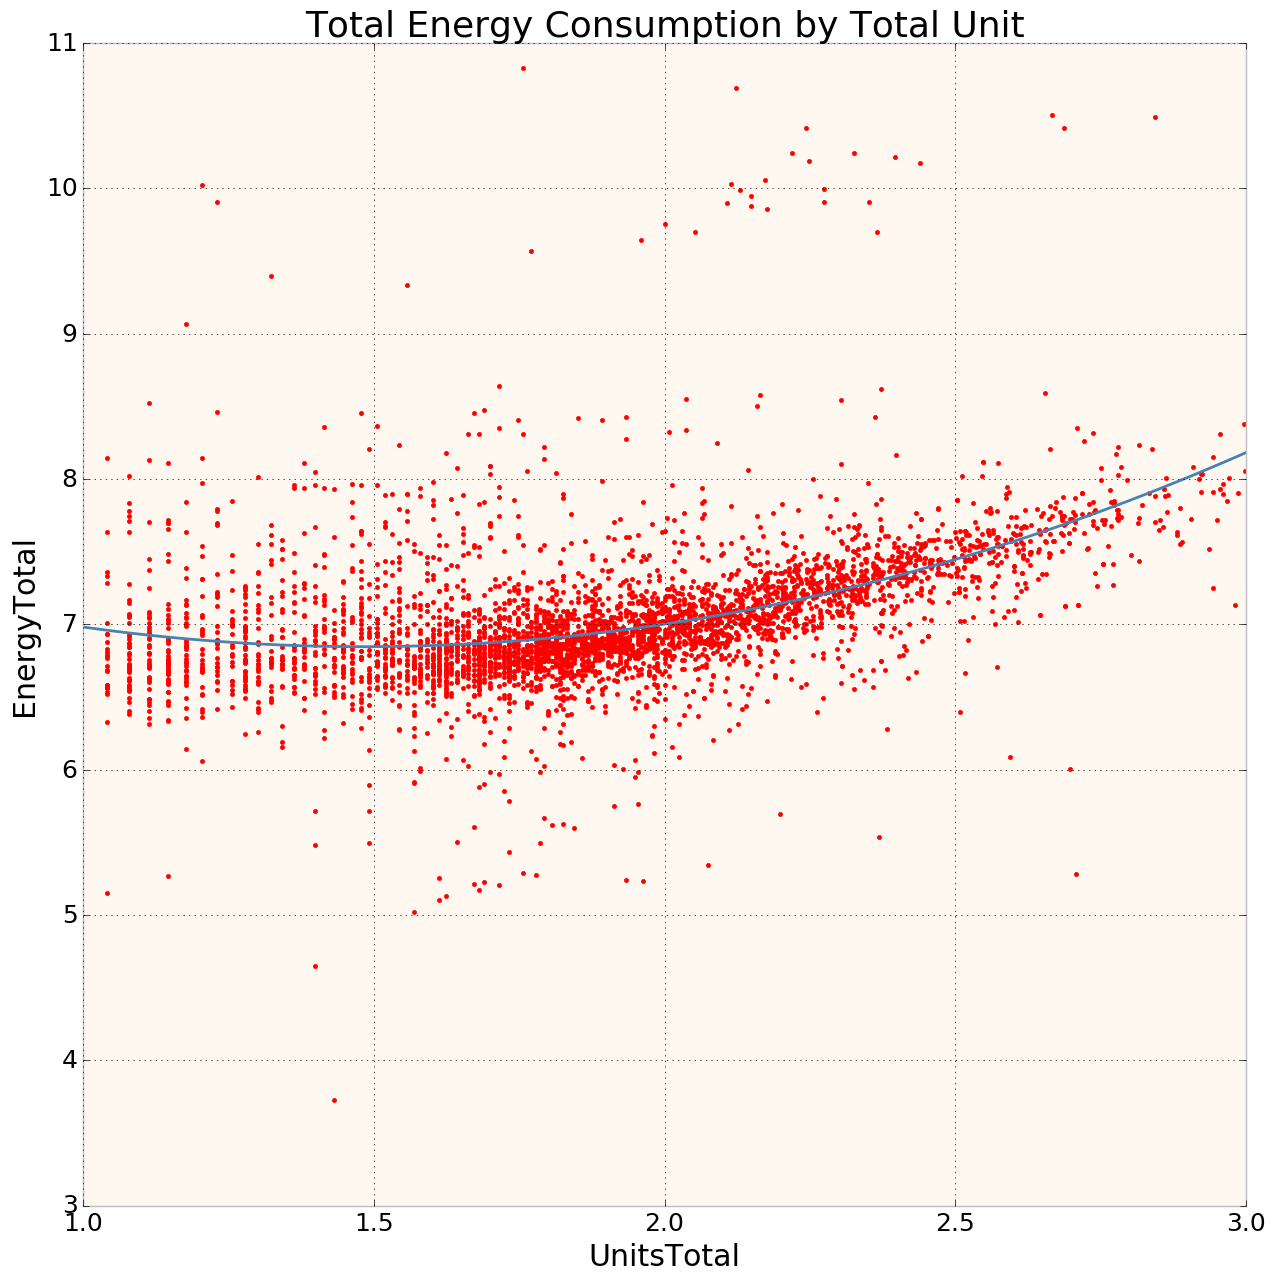

In [128]:
#helpful poly fit notes: http://stackoverflow.com/questions/18767523/fitting-data-with-numpy
xp = np.linspace(1, 3, 100)
coefs = np.polyfit(np.log10(merged['UnitsTotal']), np.log10(merged['EnergyTotal']), 2)
fit = np.poly1d(coefs)

pl.figure(figsize=(15,15))
pl.plot(np.log10(merged['UnitsTotal']), np.log10(merged['EnergyTotal']), 'r.')
pl.plot(xp, fit(xp))
pl.ylabel("EnergyTotal")
pl.xlabel("UnitsTotal")
pl.title("Total Energy Consumption by Total Unit")

### Caption for plot
This plot depicts energy consumption as a function of building units with a second degree polynomial line fit. 

### compare the units vs energy line fit and the units vs energy 2nd degree polynomial fit with the likelihood ratio test

In [41]:
#at alpha .05, a linear model is preferable to the exponentiated model

In [42]:
#this is the opposite sign of the value below
LR = -2 * (results_2.llf - poly_units_energy.llf)
print(LR)

313.805349513


In [43]:
#The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1

In [44]:
print("LR : ", -2 * (-results_2.llf - (-poly_units_energy.llf)))
print("LR from statsmodels:", poly_units_energy.compare_lr_test(results_2))

('LR : ', -313.8053495129725)
('LR from statsmodels:', (313.8053495129725, 3.2379559949861681e-70, 1.0))


### the exponentiated fit is better than the linear model

## extra credit

In [45]:
#calculate and plot the likelihood surface

In [46]:
#get creative with the dataset. can you make an insigntful plot to show any structure in the data?